# Model Building

In [2]:
import tensorflow as tf
from tensorflow import keras
from keras import layers
from keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt

In [3]:
import os

num_skipped = 0
for folder_name in ("1c", "1e","2c", "2e","10c", "20c","50c"):
    folder_path = os.path.join("/content/Coins/new_extended_dataset/original", folder_name)
    for fname in os.listdir(folder_path):
        fpath = os.path.join(folder_path, fname)
        try:
            fobj = open(fpath, "rb")
            is_jfif = tf.compat.as_bytes("JFIF") in fobj.peek(10)
        finally:
            fobj.close()

        if not is_jfif:
            num_skipped += 1
            # Delete corrupted image
            os.remove(fpath)

print("Deleted %d images" % num_skipped)

Deleted 0 images


In [4]:
batch_size=64   
target_size = 200

In [5]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "/content/Coins/new_extended_dataset/original",
    validation_split=0.2,
    subset="training",
    seed=1337,
    image_size=(target_size,target_size),
    batch_size=batch_size,
)

Found 9664 files belonging to 8 classes.
Using 7732 files for training.


In [6]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "/content/Coins/new_extended_dataset/original",
    validation_split=0.2,
    subset="validation",
    seed=1337,
    image_size=(target_size,target_size),
    batch_size=batch_size,
)

Found 9664 files belonging to 8 classes.
Using 1932 files for validation.


In [7]:
data_augmentation = keras.Sequential([
  layers.RandomFlip("horizontal_and_vertical"),
  layers.RandomRotation(0.2),
  layers.RandomContrast(factor=0.5),
])


In [8]:
train_ds = train_ds.prefetch(buffer_size=64)
val_ds = val_ds.prefetch(buffer_size=64)

Modelbuilding

In [9]:
inputs = keras.Input(shape=(target_size,target_size, 3))

x = data_augmentation(inputs)

x = layers.Rescaling(1.0 / 255)(x)

x = layers.Conv2D(filters=16, kernel_size=3, strides=2, padding="same", activation="relu")(x)
x = layers.BatchNormalization()(x)

x = layers.Conv2D(filters=32, kernel_size=3, padding="same", activation="relu")(x)
x = layers.BatchNormalization()(x)

previous_block_activation = x  # Set aside residual

for n_filters in [64, 128, 256, 512]:
    x = layers.Conv2D(filters=n_filters, kernel_size=3, padding="same", activation="relu")(x)
    x = layers.BatchNormalization()(x)

    x = layers.Conv2D(filters=n_filters, kernel_size=3, padding="same", activation="relu")(x)
    x = layers.BatchNormalization()(x)

    x = layers.MaxPooling2D(pool_size=3, strides=2, padding="same")(x)

    # Project residual
    residual = layers.Conv2D(n_filters, 1, strides=2, padding="same")(previous_block_activation)
    x = layers.add([x, residual])  # Add back residual
    previous_block_activation = x  # Set aside next residual


x = layers.Conv2D(filters=728, kernel_size=3, padding="same", activation="relu")(x)
x = layers.BatchNormalization()(x)


x = layers.SpatialDropout2D(0.5)(x)
#Flatten hat in den vorherigen Modellen bessere Ergebnisse erzeugt
#x = layers.GlobalAveragePooling2D()(x)
x = layers.Flatten()(x)

outputs = layers.Dense(8, activation="softmax")(x)
model = keras.Model(inputs=inputs, outputs=outputs)

model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 200, 200, 3  0           []                               
                                )]                                                                
                                                                                                  
 sequential (Sequential)        (None, 200, 200, 3)  0           ['input_1[0][0]']                
                                                                                                  
 rescaling (Rescaling)          (None, 200, 200, 3)  0           ['sequential[0][0]']             
                                                                                                  
 conv2d (Conv2D)                (None, 100, 100, 16  448         ['rescaling[0][0]']          

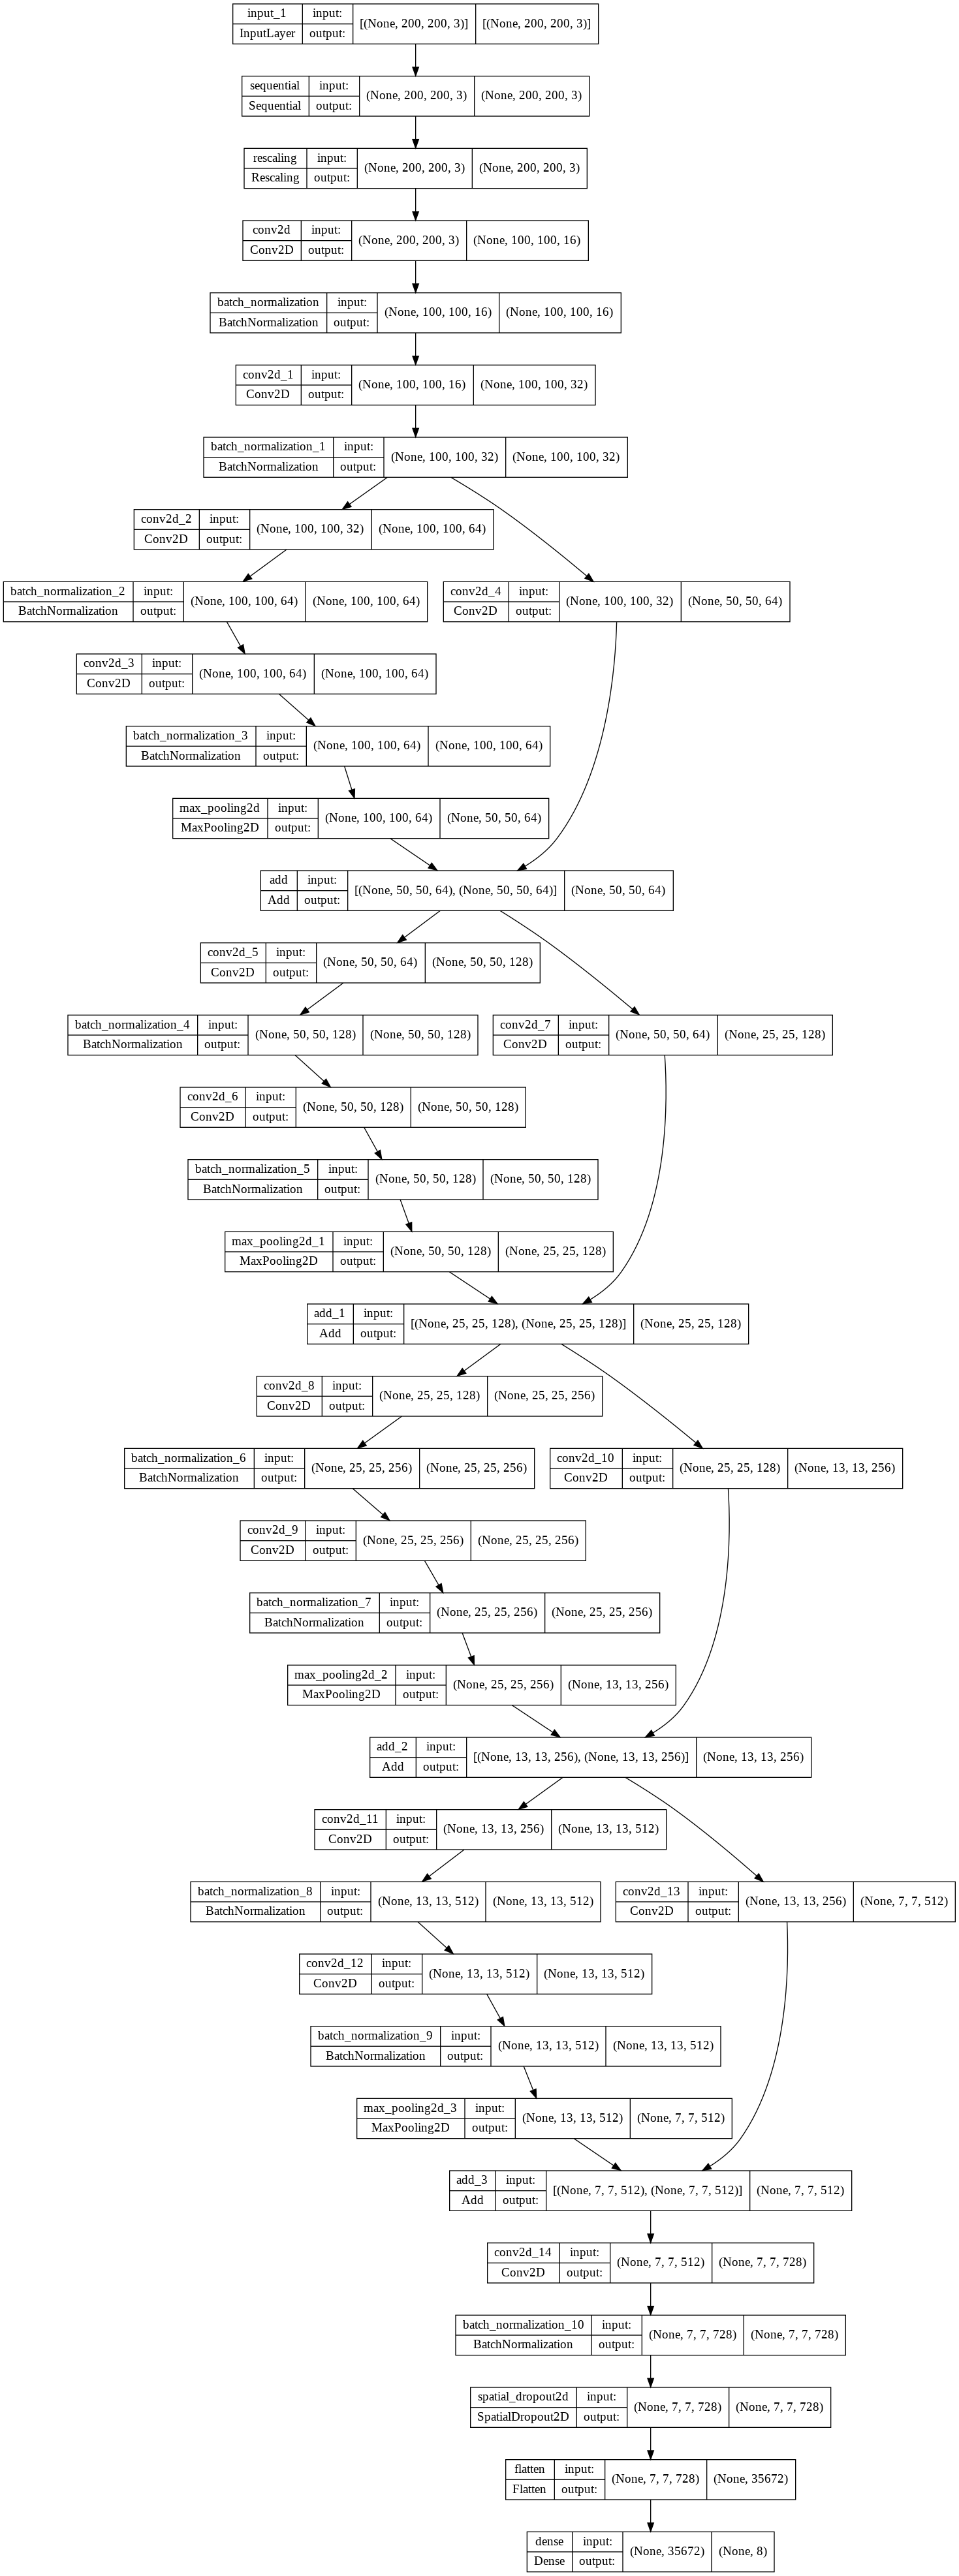

In [10]:
keras.utils.plot_model(model, show_shapes=True)

In [11]:
callbacks = [
    keras.callbacks.ModelCheckpoint("/content/Coins/Models/advance_model", save_best_only=True),
    #keras.callbacks.EarlyStopping(monitor="val_loss", min_delta=0.01, patience=4)
]

In [12]:
#'categorical_crossentropy' works on one-hot encoded target, while 'sparse_categorical_crossentropy' works on integer target.
model.compile(optimizer="adam",
             loss="sparse_categorical_crossentropy",
             metrics=["accuracy"])

Model training

In [13]:
epochs=50

history = model.fit(
    train_ds, 
    epochs=epochs, 
    callbacks=callbacks, 
    validation_data=val_ds,
)

Epoch 1/50
121/121 [==============================] - 58s 374ms/step - loss: 3.0352 - accuracy: 0.5063 - val_loss: 4.3548 - val_accuracy: 0.1993
Epoch 2/50
121/121 [==============================] - 33s 268ms/step - loss: 1.4102 - accuracy: 0.6083 - val_loss: 4.5302 - val_accuracy: 0.1765
Epoch 3/50
121/121 [==============================] - 39s 314ms/step - loss: 0.8471 - accuracy: 0.6950 - val_loss: 3.0137 - val_accuracy: 0.3209
Epoch 4/50
121/121 [==============================] - 39s 315ms/step - loss: 0.7919 - accuracy: 0.7280 - val_loss: 0.8798 - val_accuracy: 0.6667
Epoch 5/50
121/121 [==============================] - 34s 272ms/step - loss: 0.8046 - accuracy: 0.7437 - val_loss: 1.2583 - val_accuracy: 0.6894
Epoch 6/50
121/121 [==============================] - 39s 319ms/step - loss: 0.6493 - accuracy: 0.7602 - val_loss: 0.5579 - val_accuracy: 0.7914
Epoch 7/50
121/121 [==============================] - 34s 273ms/step - loss: 0.6157 - accuracy: 0.7931 - val_loss: 1.0667 - val_ac

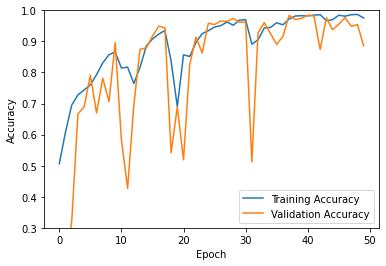

In [14]:
epochs_range = range(epochs)

plt.plot(epochs_range, history.history['accuracy'], label='Training Accuracy')
plt.plot(epochs_range, history.history['val_accuracy'], label = 'Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.3, 1])
plt.legend(loc='lower right')